In [116]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
from os import listdir
from os.path import isfile, join
import skfda
from skfda.representation.interpolation import SplineInterpolation
from skfda.exploratory.visualization import Boxplot
import datetime as dt
from numpy.polynomial.polynomial import polyfit
from sklearn.metrics import mean_squared_error

In [117]:
# Variabili globali

path = 'pala_ok/acquisizione 22-05-2023/'

In [118]:
allacqui_temp = []

allacqui_input = []

# Andiamo a prendere tutti i path dei vari file

path_acquisizioni = [f for f in listdir(path) if isfile(join(path, f))]


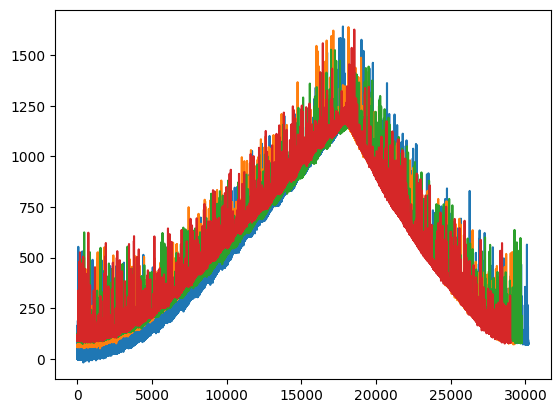

In [119]:
# Abbiamo usato il range siccome i csv hanno separatori diversi

for a,b in zip(path_acquisizioni,range(0,len(path_acquisizioni))):
    if("input" in a):
        allacqui_input.append(pd.read_csv(path+a,sep='\t'))
    else:
        allacqui_temp.append(pd.read_csv(path+a,sep='\t').drop_duplicates(subset=['time'],keep='last',ignore_index=True))

allacqui = []
for a,b in zip(allacqui_temp,range(len(allacqui_temp))):
    if(b % 3 ==0):
        allacqui.append([])
        a['Voltage'] = (10 - a['Voltage'])*500
        plt.plot(a['Voltage'])
    allacqui[-1].append(a)



In [120]:
all_acqui_new = []

for a in range(len(allacqui_input)):
    all_acqui_new.append([])
    for b in range(3):
        all_acqui_new[-1].append(
            allacqui[a][b][(allacqui[a][b]['time'] > allacqui_input[a]['time'][allacqui_input[a]['pwm_percent'] == 37].values[0])
                           & (allacqui[a][b]['time'] < allacqui_input[a]['time'][allacqui_input[a]['pwm_percent'] == 77].values[0])]
        )

pwm_max = 2000
pwm_min = 1000


'''for a in range(len(allacqui_input)):
    allacqui_input[a] = pwm_min + ((allacqui_input[a] * (pwm_max-pwm_min))/100)'''

    


'for a in range(len(allacqui_input)):\n    allacqui_input[a] = pwm_min + ((allacqui_input[a] * (pwm_max-pwm_min))/100)'

In [121]:
print(allacqui_input[0])

                time  pwm_percent
0   1684770601025368            2
1   1684770604032476            7
2   1684770607045914           12
3   1684770610059281           17
4   1684770613074306           22
5   1684770616075352           27
6   1684770619088353           32
7   1684770622096963           37
8   1684770625107251           42
9   1684770628120158           47
10  1684770631127954           52
11  1684770634144826           57
12  1684770637156567           62
13  1684770640163460           67
14  1684770643179780           72
15  1684770646193384           77
16  1684770649204112           82
17  1684770652221010           87
18  1684770655235112           92
19  1684770658243264           97
20  1684770661250534          100
21  1684770664264388           95
22  1684770666273388           90
23  1684770668278176           85
24  1684770670287292           80
25  1684770672298299           75
26  1684770674307357           70
27  1684770676322968           65
28  1684770678

In [122]:
allacqui = all_acqui_new

In [123]:
for a in range(len(allacqui)):
    for b in range(len(allacqui[0])):
        allacqui[a][b].reset_index(drop=True,inplace=True)

In [124]:
print(allacqui[0][0].head(10).index.tolist())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [125]:
# Check delle dimensioni

print(type(allacqui[0][0][:10].mean()))

for a in range(len(allacqui[0])):
    print(allacqui[0][a].shape)

<class 'pandas.core.series.Series'>
(7199, 2)
(6969, 2)
(6996, 2)


In [126]:
def moving_average(a, n=10) :
    ret = np.cumsum(a)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [127]:
#media mobile
#allacqui[0][0] = allacqui[0][0].rolling(10,min_periods = 1,center=False).mean()

#mediana mobile
allacqui[0][0] = allacqui[0][0].rolling(30,min_periods = 1,center=False).median()

In [128]:
print(type(allacqui[0][0]))
print(allacqui[0][0].head(10))

<class 'pandas.core.frame.DataFrame'>
           time     Voltage
0  1.684771e+15  188.253488
1  1.684771e+15  187.607315
2  1.684771e+15  188.253488
3  1.684771e+15  189.141976
4  1.684771e+15  190.030464
5  1.684771e+15  189.141976
6  1.684771e+15  188.253488
7  1.684771e+15  187.849630
8  1.684771e+15  188.253488
9  1.684771e+15  188.576574


In [129]:
print(allacqui[0][2]['volts'].shape)
print(allacqui[0][2].head(10))

(6996,)
               time   volts
0  1684770622101961  16.553
1  1684770622104960  16.553
2  1684770622108960  16.553
3  1684770622109962  16.553
4  1684770622111962  16.553
5  1684770622116965  16.553
6  1684770622118960  16.553
7  1684770622121984  16.553
8  1684770622123958  16.553
9  1684770622126960  16.553


In [130]:
# Andiamo a lavorare sui dati di national instrument, ne riduciamo le dimensioni usando la media

data_matrix = allacqui[0][2]['volts']
grid_points = allacqui[0][2]['time']

fd_manu = skfda.FDataGrid(
    data_matrix=data_matrix,
    grid_points=grid_points,
    dataset_name="Datagrid di esempio",
    argument_names=('time',),
    coordinate_names=('values',),
    interpolation=SplineInterpolation(interpolation_order=1)
)

c:\Users\pc\anaconda3\envs\manutenzione\lib\site-packages\skfda\exploratory\depth\multivariate.py:276: RuntimeWarning: invalid value encountered in divide
  return (  # type: ignore[no-any-return]


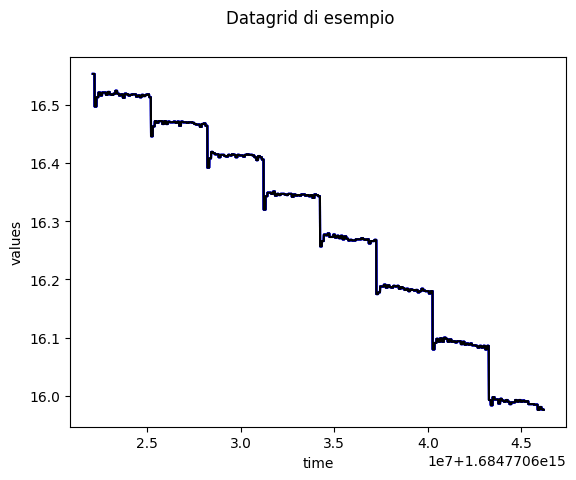

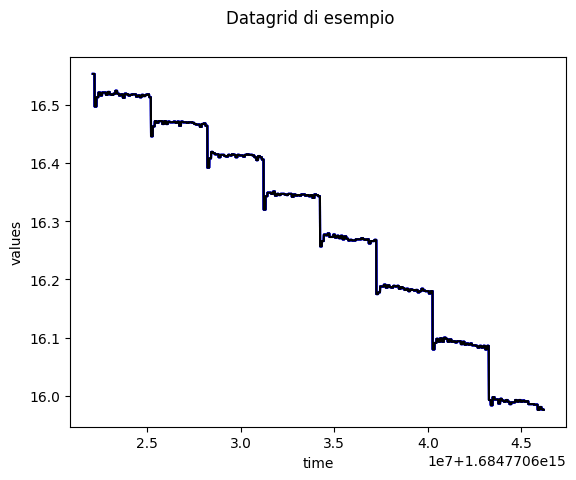

In [131]:
fdBoxplot = Boxplot(fd_manu)
fdBoxplot.show_full_outliers = True
fdBoxplot.plot()

In [132]:
import numpy as np
def makepwm(d):
    off_setList = len([d-x for x in b['time'] if (d - x > 0)])
    if(off_setList == 0):
       return 0
    else:
      return b['pwm_percent'][off_setList-1]
makepwmElem = np.vectorize(makepwm)

In [133]:
all_PWMoutput = []

for acquisizione,b in zip(allacqui,allacqui_input): 
    
    all_PWMoutput.append([])
    for timestamp in acquisizione:
        all_PWMoutput[-1].append([])
        all_PWMoutput[-1][-1] = pwm_min + ((makepwmElem(timestamp['time']) * (pwm_max-pwm_min))/100)
        
        


In [134]:
print(len(all_PWMoutput))

print(all_PWMoutput[0][0])

4
[1370. 1370. 1370. ... 1720. 1720. 1720.]


In [135]:
print(all_PWMoutput)
print(len(all_PWMoutput))
print(len(all_PWMoutput[0]))

for pwmoutput,acqui in zip(all_PWMoutput,allacqui):
    for a,b in zip(pwmoutput,acqui):

        print(len(a))
        print(type(a))
        print(len(b))
        print(type(b))
        print(' Questi sono i valori di a e b')

    

[[array([1370., 1370., 1370., ..., 1720., 1720., 1720.]), array([1370., 1370., 1370., ..., 1720., 1720., 1720.]), array([1370., 1370., 1370., ..., 1720., 1720., 1720.])], [array([1370., 1370., 1370., ..., 1720., 1720., 1720.]), array([1370., 1370., 1370., ..., 1720., 1720., 1720.]), array([1370., 1370., 1370., ..., 1720., 1720., 1720.])], [array([1370., 1370., 1370., ..., 1720., 1720., 1720.]), array([1370., 1370., 1370., ..., 1720., 1720., 1720.]), array([1370., 1370., 1370., ..., 1720., 1720., 1720.])], [array([1370., 1370., 1370., ..., 1720., 1720., 1720.]), array([1370., 1370., 1370., ..., 1720., 1720., 1720.]), array([1370., 1370., 1370., ..., 1720., 1720., 1720.])]]
4
3
7199
<class 'numpy.ndarray'>
7199
<class 'pandas.core.frame.DataFrame'>
 Questi sono i valori di a e b
6969
<class 'numpy.ndarray'>
6969
<class 'pandas.core.frame.DataFrame'>
 Questi sono i valori di a e b
6996
<class 'numpy.ndarray'>
6996
<class 'pandas.core.frame.DataFrame'>
 Questi sono i valori di a e b
7039
<

In [136]:
# Andiamo a definire un datagrid per ogni dataframe con NUOVE SPECIFICHE

all_data_grid = []
datasetTitles = ['National Instrument','RPM','Battery']
for pwmoutput,acqui in zip(all_PWMoutput,allacqui):
    all_data_grid.append([])
    for a,b,i in zip(acqui,pwmoutput,range(len(acqui))):        
        data_matrix = np.stack((np.array(a[a.columns.values[1]]), np.array(b)))
        grid_points = a[a.columns.values[0]]

        all_data_grid[-1].append(skfda.FDataGrid(
        data_matrix=data_matrix,
        grid_points=grid_points,
        dataset_name=datasetTitles[i],
        argument_names=(a.columns.values[0],),
        coordinate_names=(a.columns.values[1],),
        interpolation=SplineInterpolation(interpolation_order=1)
        ))
    

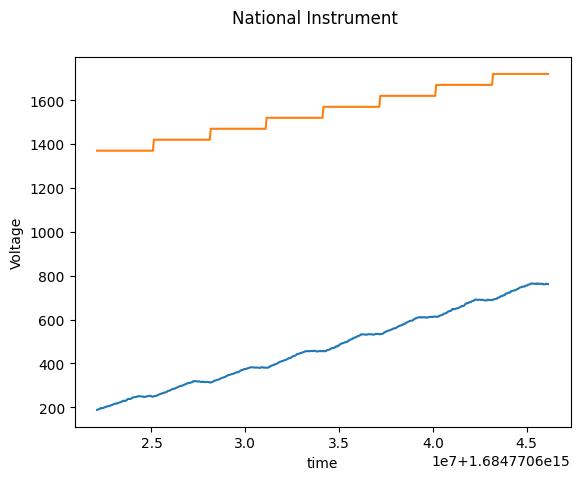

In [137]:
all_data_grid[0][0].plot()
print()

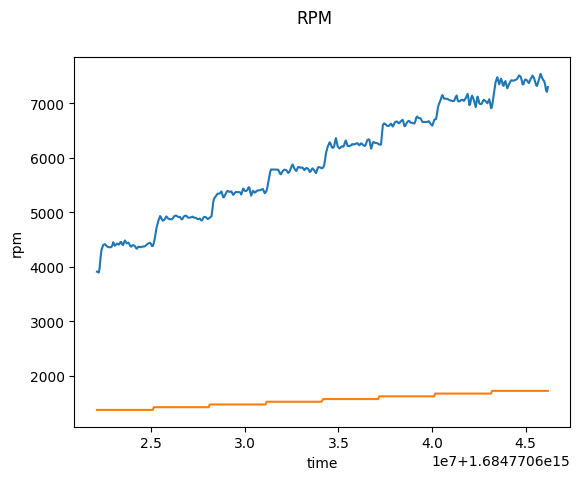

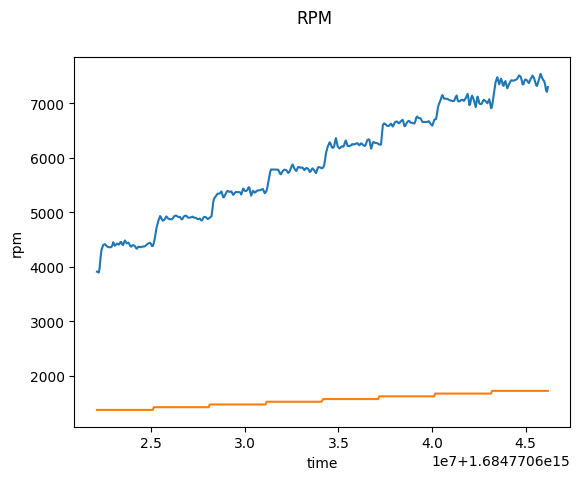

In [138]:
all_data_grid[0][1].plot()

765.3667167833191


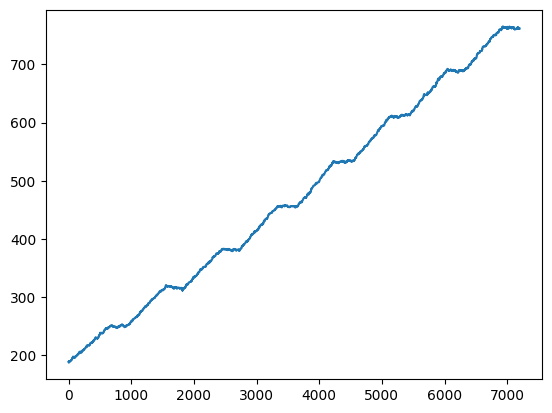

In [139]:
print(all_data_grid[0][0].data_matrix[0].max())
plt.plot(all_data_grid[0][0].data_matrix[0])


In [140]:
#Fitting for National Instrument
pol_maxGrade = 4 # afte the grade 5 it become glitchy
fit_result = []
for acquisizione in all_data_grid:
    fit_result.append([])
    for dataset in acquisizione:

        fit_result[-1].append([])
        for i in range(pol_maxGrade):
            fit_result[-1][-1].append(polyfit(dataset.data_matrix[1][:,0],dataset.data_matrix[0],deg=i+1))


polinomio:1 [[-1.79423862e+03]
 [ 1.46848044e+00]]
polinomio:2 [[-5.28936223e+02]
 [-1.79015081e-01]
 [ 5.33332017e-04]]
polinomio:3 [[ 4.25141110e+03]
 [-9.52321944e+00]
 [ 6.60188166e-03]
 [-1.30948684e-06]]
polinomio:4 [[-5.75956409e+04]
 [ 1.51689222e+02]
 [-1.50625573e-01]
 [ 6.66889645e-05]
 [-1.10035001e-08]]
polinomio:1 [[-7400.06825737]
 [    8.64209924]]
polinomio:2 [[-1.66370711e+04]
 [ 2.06648527e+01]
 [-3.89055159e-03]]
polinomio:3 [[-1.30371377e+04]
 [ 1.36292999e+01]
 [ 6.77796952e-04]
 [-9.85578843e-07]]
polinomio:4 [[-5.14278214e+05]
 [ 1.32010040e+03]
 [-1.27341718e+00]
 [ 5.50003688e-04]
 [-8.91546872e-08]]
polinomio:1 [[ 1.86157793e+01]
 [-1.50781877e-03]]
polinomio:2 [[ 1.42552337e+01]
 [ 4.16738563e-03]
 [-1.83637955e-06]]
polinomio:3 [[ 1.33918478e+01]
 [ 5.85477715e-03]
 [-2.93206243e-06]
 [ 2.36388059e-10]]
polinomio:4 [[ 3.00990439e+01]
 [-3.76910899e-02]
 [ 3.95337965e-05]
 [-1.81278544e-08]
 [ 2.97143778e-12]]
polinomio:1 [[-1.53742172e+03]
 [ 1.32285656e+00

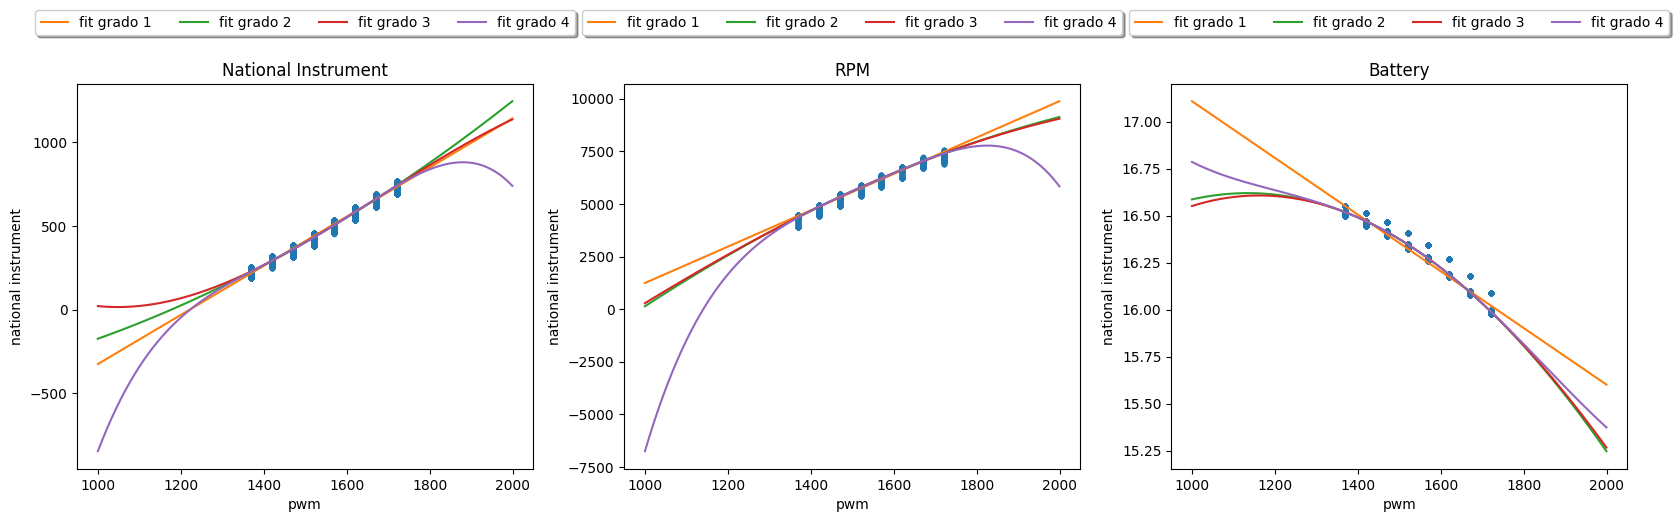

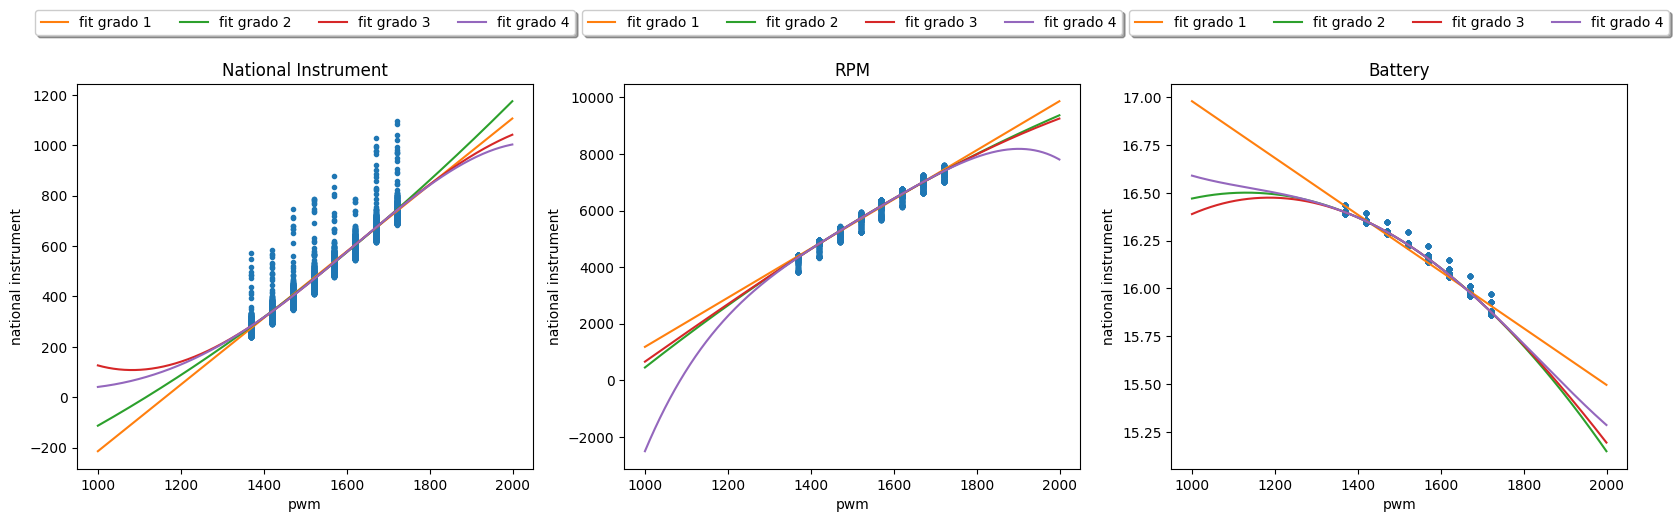

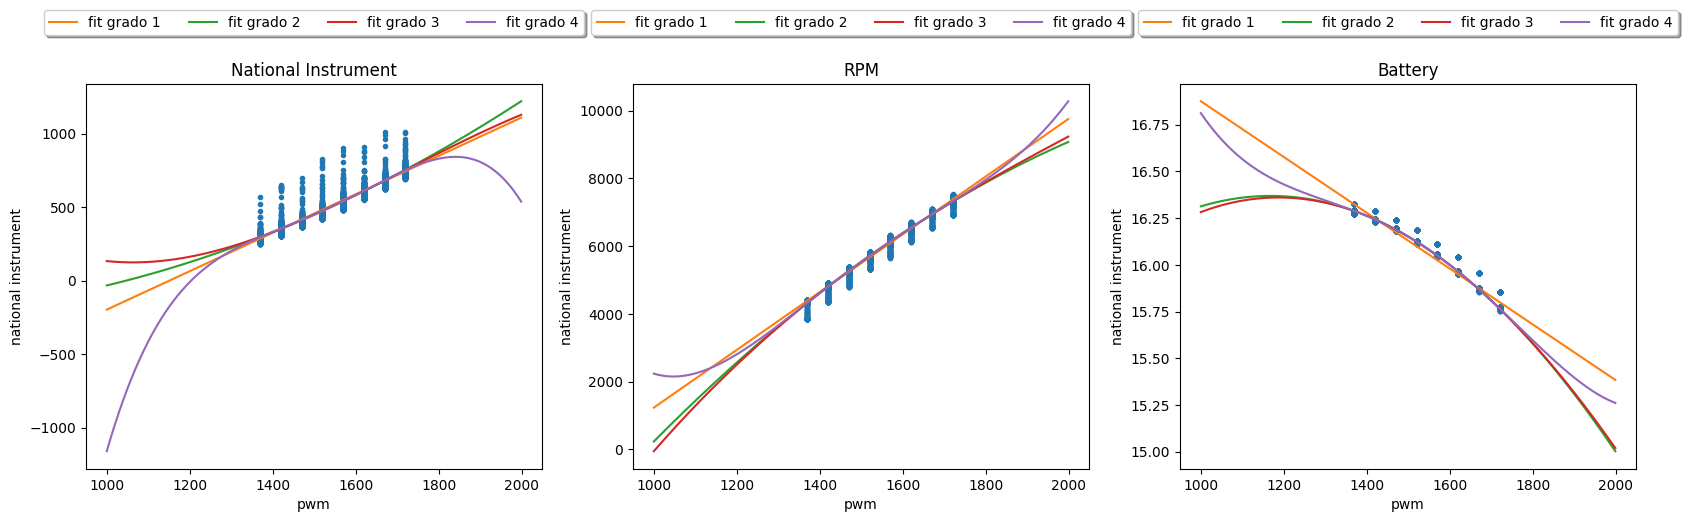

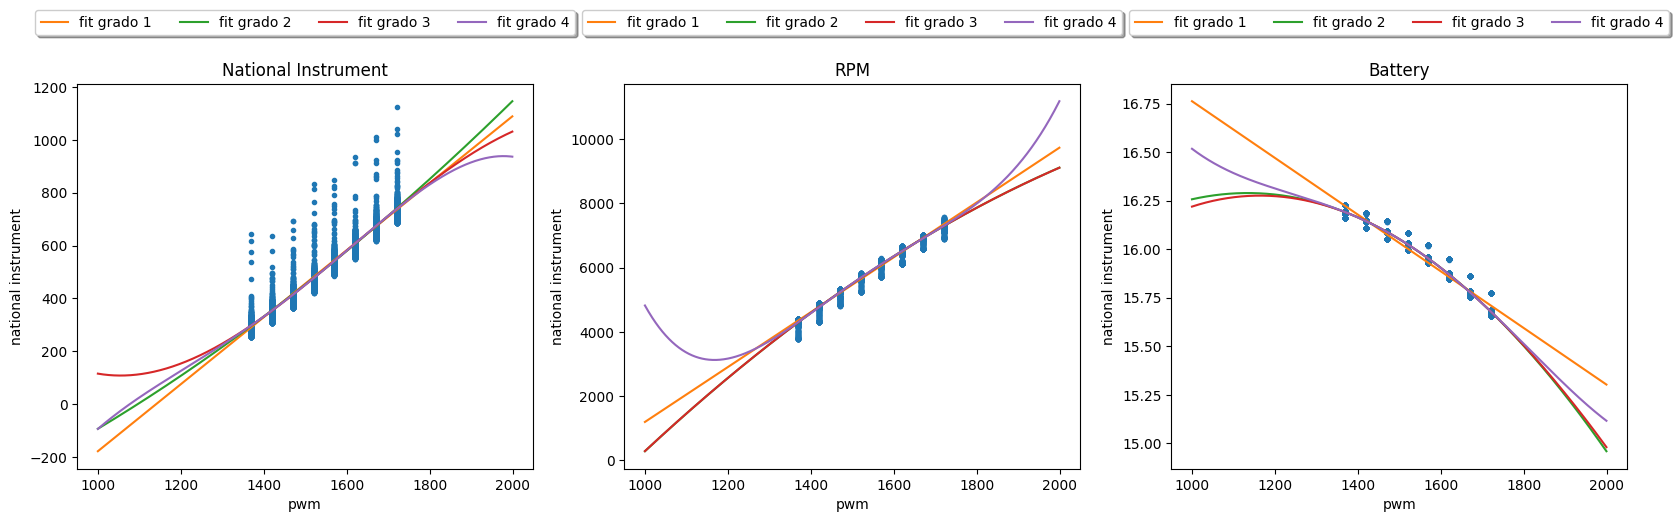

In [141]:

for acquisizione,fit_set in zip(all_data_grid,fit_result):
    fig, axs = plt.subplots(nrows = 1, ncols = 3)
    fig.set_size_inches(h=5,w=20)
    
    linex = np.arange(pwm_min,pwm_max,1,dtype='longdouble')
    
    for dataset,dataset_fit,index in zip(acquisizione,fit_set,range(len(acquisizione))):
        axs[index].plot(dataset.data_matrix[1][:,0],dataset.data_matrix[0],'.')
        axs[index].set_xlabel('pwm')
        axs[index].set_ylabel('national instrument')
        for fit,indice in zip(dataset_fit,range(pol_maxGrade)):
            plotRes = np.array([0]*(pwm_max-pwm_min),dtype='longdouble')
            for i in range(len(fit)):
                plotRes += np.multiply(fit[i],np.power(linex,i))
            print("polinomio:"+ str(len(fit)-1)+' '+str(fit))
            #pd.DataFrame({'linex':linex,'value':plotRes}).to_csv('csv/'+str(index)+str(indice)+'.csv','\t',index=False)
            axs[index].plot(linex, plotRes,'-',label='fit grado '+str(indice+1))
        axs[index].set_title(datasetTitles[index])
        axs[index].legend(loc='upper center', bbox_to_anchor=(0.5, 1.21),ncol=4, fancybox=True, shadow=True)

In [142]:
# Andiamo a calcolare il mean squared error
grafico = 0
y_pred = all_data_grid[grafico][0].data_matrix[0]
for fit,g in zip(fit_result[grafico][0],range(len(fit_result[1][0]))):
    y_true = 0
    for i in range(len(fit)):
        y_true += fit[i]*all_data_grid[grafico][0].data_matrix[1][:,0]**i
    print('grado' + str(g+1))
    print(mean_squared_error(y_true, y_pred[:,0]))

grado1
654.2336757043579
grado2
616.9067801268667
grado3
614.9202435049053
grado4
613.8475917506344


In [143]:
for a in fit_result:
    print(type(a[0][2]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
